# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns
from tqdm import tqdm

In [2]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [3]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [5]:
print(dataset['Score'].value_counts() )                       # Printing the number of each classes (positive and negative reviews)
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


In [6]:
# Printing first few rows as a sample of the dataset
# You may pass the number of rows to be displayed as an argument to the head() method

dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [7]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [9]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [10]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

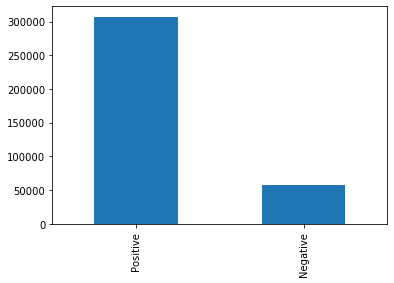

In [11]:
# Getting the number of positive and negative reviews

data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### 2.2 Data Cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [15]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [16]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{'do', 'ain', 'then', 'while', 'or', 'above', 'an', 'to', 'most', 'same', "hasn't", "needn't", 'did', 'in', 'before', 'own', 'myself', 'other', 'our', 'were', 'does', 'each', 'won', 'few', 'hers', 'but', 'll', 'because', "she's", 'into', 'any', 'ours', 'the', 'hasn', 'me', 'more', 'where', 'with', "won't", 'not', 'against', 'over', "shouldn't", 'had', 'on', 'your', "you're", 'have', 'd', 'has', 'doesn', 's', 'y', 'being', "didn't", "mustn't", 'm', "weren't", 'don', 't', 'shan', 'mightn', 'between', 'out', 'as', 'doing', 'nor', "wasn't", 'after', 've', 'aren', 'been', 'again', 'only', 'will', 'he', 'should', 'shouldn', "it's", 'all', 'hadn', 'my', 'of', 'their', 'for', 'both', 'what', 'yourself', 'off', 'yourselves', 'yours', 'those', 'them', 'how', 'him', 'some', 'whom', 'and', 'can', 'about', 'when', 'down', 'o', 'haven', 'was', 'just', 'now', 'having', 'they', 'further', 'her', "should've", 'from', "shan't", "you'll", "you've", "don't", 'am', 'is', 'we', "you'd", 'herself', "mightn't

In [17]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [18]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [19]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in tqdm(data['Text'].values):
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

100%|██████████| 364131/364131 [05:10<00:00, 1173.60it/s]


In [20]:
# Adding a column in dataset and storing cleaned text in it.

data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [21]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [22]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Splitting data into Train, Test and Cross-validation

X = time_sort['CleanedText']
Y = time_sort['Score']

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [25]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the CV data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


# 4. Function to Train and Test Naive Baye's models

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### 4.1 Train function for Naive Baye's models

In [27]:
def nb_train(x_train, x_cv, y_train, y_cv, algo):
    alpha = [10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001,0.000005,0.000001]
    accuracy_cv = []

    for i in alpha[0:]:
        if (algo == 'Multinomial'):
            nb = MultinomialNB(alpha=i)
        elif (algo == 'Bernoulli'):
            nb = BernoulliNB(alpha=i)
        nb.fit(x_train, y_train)
        
        prediction = nb.predict(x_cv)
        
        acc_cv = accuracy_score(y_cv, prediction)
        f1_cv = f1_score(y_cv, prediction, average='macro')
        precision_cv = precision_score(y_cv, prediction, average='macro')
        recall_cv = recall_score(y_cv, prediction, average='macro')
        
        print("FOR α =", i)
        print("The accuracy of the model is:", acc_cv*100)
        print("The f1_score of the model is:", f1_cv*100)
        print("The precision_score of the model is:", precision_cv*100)
        print("The recall_score of the model is:", recall_cv*100)
        print("=="*60)
        
        accuracy_cv.append(acc_cv)
        
    # Plot λ vs auc_score graph
    plt.plot(alpha, accuracy_cv, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("α v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('alpha (α)')
    plt.show()

### 4.2 Test function for Naive Baye's models

In [28]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [29]:
def nb_test(x_train, y_train, x_test, y_test, optimal_alpha, algo):
    if (algo == 'Multinomial'):
        nb = MultinomialNB(alpha=optimal_alpha)
    elif (algo == 'Bernoulli'):
        nb = BernoulliNB(alpha=optimal_alpha)
    nb.fit(x_train, y_train)
    
    prediction = nb.predict(x_test)

    print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
    print("The macro f1_score of the model is:", f1_score(y_test, prediction, average = 'macro')*100)
    print("The micro f1_score of the model is:", f1_score(y_test, prediction, average = 'micro')*100)
    print("The precision_score of the model is:", precision_score(y_test, prediction, average='macro')*100)
    print("The recall_score of the model is:", recall_score(y_test, prediction, average='macro')*100)
    print("The precision recall report for data:\n", classification_report(y_test, prediction))
    
    plot_confusion_matrix(y_test, prediction)
    plt.show()

# 5. Vectorization of splitted of data

### 5.1 Bag of Words (BoW)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [32]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1927099) (191168,)
The shape of the CV data is: (81930, 1927099) (81930,)
The shape of the test data is: (91033, 1927099) (91033,)


### 5.2 Term Frequency - Inverse Document Frequency (tf-idf)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [35]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1927099) (191168,)
The shape of the CV data is: (81930, 1927099) (81930,)
The shape of the test data is: (91033, 1927099) (91033,)


### 5.3 Word2Vec

In [36]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [37]:
sentence_list = []
for sentence in x_train:
    sentence_list.append(sentence.split())

In [38]:
sentence_list_cv = []
for sentence in x_cv:
    sentence_list_cv.append(sentence.split())

In [39]:
sentence_list_test = []
for sentence in x_test:
    sentence_list_test.append(sentence.split())

In [40]:
# Train your own Word2Vec model using your own train text corpus 

w2v_train_model = Word2Vec(sentence_list, min_count=5, size=50, workers=4)          # Considers only those words that occured atleast 5 times
print(type(w2v_train_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [41]:
w2v_words = list(w2v_train_model.wv.vocab)
print("The number of words that occured minimum 5 times:", len(w2v_words))
print("These are the sample words from index 0 to 50:/n", w2v_words[0:50])

The number of words that occured minimum 5 times: 16314
These are the sample words from index 0 to 50:/n ['whole', 'famili', 'love', 'jerki', 'tender', 'wonder', 'flavor', 'plan', 'keep', 'sever', 'bag', 'hand', 'last', 'minut', 'gift', 'best', 'cracker', 'ever', 'tast', 'made', 'butter', 'english', 'compani', 'also', 'make', 'water', 'wheat', 'given', 'along', 'french', 'chees', 'surpris', 'good', 'oval', 'larg', 'break', 'piec', 'put', 'whatev', 'like', 'excel', 'perfect', 'background', 'interfer', 'top', 'great', 'one', 'favorit', 'way', 'eat']


### 5.4 Average Word2Vec

In [42]:
avg_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):          # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_train_vector.append(sentence_vector)
avg_train_vector = np.array(avg_train_vector)

100%|██████████| 191168/191168 [00:22<00:00, 8674.52it/s]


In [43]:
print(avg_train_vector.shape)
print(avg_train_vector[0])

(191168, 50)
[-0.57527411  0.42825057 -1.35049552  0.20452343 -0.35911884 -1.45044472
  1.0849341   0.51102698 -1.06160346 -0.20090812  0.02794901 -0.85689317
 -0.27523283  0.55358428 -0.17980464  0.21554652 -0.53138368 -0.29003145
  0.24540532  0.05768674 -0.26382949 -1.02637844 -0.24406199  0.27483706
 -0.40157924 -0.13711834 -0.62798274 -0.27209253  1.39489218  1.44716302
 -0.51723371 -0.60757087  0.28708753  0.20975042 -0.27978154  0.80874302
  0.00157003  0.64039747 -0.43490545  0.63699134 -0.205429   -0.95098598
  0.23814236 -0.33356692 -0.53533012 -0.16609469  1.13160052 -1.10665832
  0.52985088  0.58324567]


In [44]:
avg_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):       # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_cv_vector.append(sentence_vector)
avg_cv_vector = np.array(avg_cv_vector)

100%|██████████| 81930/81930 [00:09<00:00, 9006.66it/s]


In [45]:
print(avg_cv_vector.shape)
print(avg_cv_vector[0])

(81930, 50)
[ 0.39642103 -0.86155834 -0.89995235 -0.53396405 -0.05809186  0.12797474
  0.12553676 -0.18919901 -0.40989741  0.53316578  0.21294884  0.39867877
 -0.75900611 -0.2294215  -0.29151854 -0.08535062 -1.22582833 -0.51977716
 -0.1531111   1.01656733 -0.0140349  -0.69638113 -0.36107527  0.32689304
  0.25863698  0.03667109 -0.21103886  0.24071915  1.09214042  0.62657342
 -0.23910586 -0.19025245  0.56502668  0.16885213 -0.30547112 -0.67216288
  1.35583505  0.03278429  0.54281421 -0.18690807 -0.63602953  0.67354958
  0.38154226 -0.15345209 -0.27957532  0.1994752   0.03276127 -0.61800881
  1.36942427 -0.06334605]


In [46]:
avg_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):     # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_test_vector.append(sentence_vector)
avg_test_vector = np.array(avg_test_vector)

100%|██████████| 91033/91033 [00:10<00:00, 9051.87it/s]


In [47]:
print(avg_test_vector.shape)
print(avg_test_vector[0])

(91033, 50)
[ 0.39855654 -0.2938176  -0.48692744 -1.00739682 -0.58863578 -0.32525966
  0.05923839 -0.24877117 -1.61767277 -0.33079888  0.30040573  0.4068658
 -0.34202942  0.81482778 -0.67633866  0.65952736 -1.36284186  0.32928445
  0.54805195 -0.41563322 -0.3906946  -0.77827304  0.49351467  0.02381737
 -0.60414652 -0.22324891  0.2868745   0.01445214  0.19476451  0.35099076
 -0.2025086  -0.39899107  1.06416512 -1.11677125 -0.17171518  0.18649691
 -0.06000366  0.44398653 -0.85559335 -0.01649879  0.10622916  0.34329716
 -0.09618247  0.19850877 -0.82627322 -0.48253831 -0.25728415 -0.70758643
  1.16266891  0.19045654]


In [48]:
x_train_avgw2v = avg_train_vector
x_cv_avgw2v = avg_cv_vector
x_test_avgw2v = avg_test_vector

In [49]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


### 5.5 TF-IDF Weighed Word2Vec

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_vect.fit_transform(x_train)
tfidf_feat = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tfidf_vect.idf_)))

In [52]:
tfidf_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):            # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_train_vector.append(sentence_vector)
tfidf_train_vector = np.array(tfidf_train_vector)

100%|██████████| 191168/191168 [00:59<00:00, 3192.15it/s]


In [53]:
print(tfidf_train_vector.shape)
print(tfidf_train_vector[0])

(191168, 50)
[-5.73395569e-01  5.83271829e-01 -1.23074571e+00 -4.32296700e-02
 -2.47918509e-01 -1.69149088e+00  1.07541454e+00  8.41069635e-01
 -4.14633364e-01 -2.36605023e-01 -1.05897879e-01 -1.34161121e+00
 -1.68416352e-01  7.98658498e-01 -3.65796486e-01  4.78672491e-01
 -9.78918345e-01 -4.16708815e-01  2.33528654e-01  1.29230224e-03
 -3.78427117e-01 -1.20492971e+00 -6.43138074e-01  2.94074957e-01
 -1.49339356e-01 -4.88582326e-01 -2.42531617e-01 -3.94180954e-03
  1.21552402e+00  1.95628584e+00 -4.23956684e-01 -3.84807453e-01
  1.58969697e-03 -2.40838270e-01 -3.57553599e-01  8.91087734e-01
 -3.11044704e-02  6.54716075e-01 -7.70603125e-01  7.00150417e-01
 -5.16646624e-01 -1.07024224e+00  5.13832115e-01 -6.11969708e-01
 -2.75545090e-01 -1.17678790e-03  9.33866888e-01 -1.28836200e+00
  9.79628986e-01  8.94144022e-01]


In [54]:
tfidf_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):         # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_cv_vector.append(sentence_vector)
tfidf_cv_vector = np.array(tfidf_cv_vector)

100%|██████████| 81930/81930 [00:25<00:00, 3196.04it/s]


In [55]:
print(tfidf_cv_vector.shape)
print(tfidf_cv_vector[0])

(81930, 50)
[ 0.20034543 -1.83734382 -1.38827275 -0.89266891  0.39921956  0.09094225
 -0.21517734 -0.32739497 -0.8691628   0.55343469  0.63367002  0.5737819
 -1.2329975  -0.60962331 -0.85561823 -0.10038432 -1.66885498 -0.60822043
 -0.12038802  1.32594677 -0.04487714 -0.23811035 -0.37947956  0.29144595
  1.0375183  -0.32643868 -0.23540843  0.44361517  1.62349383  0.47111853
  0.26869176 -0.43623176  0.96285461  0.08815667 -0.13819599 -0.61649199
  1.54301816  0.17572845  0.39610118 -0.03821713 -0.14175572  1.46564877
  0.94854181 -0.25361266 -0.8812158   0.18902984 -0.68999473 -0.23835507
  1.50280769 -0.06289027]


In [56]:
tfidf_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):       # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_test_vector.append(sentence_vector)
tfidf_test_vector = np.array(tfidf_test_vector)

100%|██████████| 91033/91033 [00:21<00:00, 4268.57it/s]


In [57]:
print(tfidf_test_vector.shape)
print(tfidf_test_vector[0])

(91033, 50)
[ 0.64025062 -0.39223722 -0.78106054 -1.04140825 -0.57741028 -1.12492907
 -0.01400693 -0.09716229 -1.7919371  -0.38928902  0.07293793  0.70913608
 -0.07492695  0.96214257 -0.59967092  0.72783876 -1.27272474  0.48845802
  0.58783431 -0.54361532 -0.3023194  -1.10240465  0.09086265 -0.2356218
 -0.63328244 -0.30195156  0.54778335  0.03304381  0.07942919  0.04139771
 -0.36926425 -0.2958212   1.36373464 -0.91162712 -0.42800596 -0.04699701
  0.24119972  0.4634963  -0.79304071 -0.02295812  0.28174184  0.25544259
  0.16520403  0.41203129 -1.26378077 -0.46020683 -0.07360141 -1.04119192
  1.25117593  0.18186415]


In [58]:
x_train_tfidfw2v = tfidf_train_vector
x_cv_tfidfw2v = tfidf_cv_vector
x_test_tfidfw2v = tfidf_test_vector

In [59]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


# 6. Applying Multinomial Naive Baye's Classifier on Our Model

### 6.1 Bag of Words (BoW)

##### 6.1.1 BoW Multinomial Naive Baye's on Train Data

FOR α = 10
The accuracy of the model is: 84.08641523251556
The f1_score of the model is: 45.799186767086866
The precision_score of the model is: 92.04165344141417
The recall_score of the model is: 50.0612838976559
FOR α = 5
The accuracy of the model is: 84.20969119980471
The f1_score of the model is: 46.595699320470885
The precision_score of the model is: 92.09355481402712
The recall_score of the model is: 50.448138501608696
FOR α = 1
The accuracy of the model is: 88.54876113755645
The f1_score of the model is: 69.72994074226985
The precision_score of the model is: 90.62221524118056
The recall_score of the model is: 65.00215351381463
FOR α = 0.5
The accuracy of the model is: 90.98986940070792
The f1_score of the model is: 79.6093823274742
The precision_score of the model is: 89.19414087305577
The recall_score of the model is: 74.82323444677522
FOR α = 0.1
The accuracy of the model is: 91.67948248504821
The f1_score of the model is: 83.11933868391796
The precision_score of the model is:

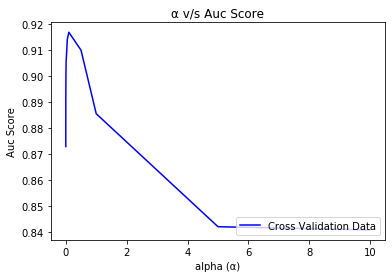

In [60]:
# Find the optimal value of alpha
# This may take several minutes(even hour/s) to run

nb_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='Multinomial')

##### 6.1.2 BoW Multinomial Naive Baye's on Test Data

The accuracy of the model is: 91.75353992508212
The macro f1_score of the model is: 83.16324615602771
The micro f1_score of the model is: 91.75353992508211
The precision_score of the model is: 86.46401849022604
The recall_score of the model is: 80.66173468550724
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.79      0.64      0.71     14351
    Positive       0.94      0.97      0.95     76682

    accuracy                           0.92     91033
   macro avg       0.86      0.81      0.83     91033
weighted avg       0.91      0.92      0.91     91033



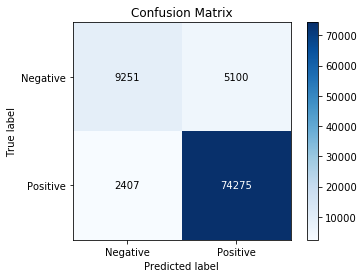

In [61]:
# Testing the final model

nb_test(x_train_bow, y_train, x_test_bow, y_test, optimal_alpha=0.1, algo='Multinomial')

### 6.2 Term Frequency - Inverse Document Frequency (tf-idf)

##### 6.2.1 TF-IDF Multinomial Naive Baye's on Train Data

FOR α = 10
The accuracy of the model is: 84.06688636641036
The f1_score of the model is: 45.67192286779041
The precision_score of the model is: 42.03344318320518
The recall_score of the model is: 50.0
FOR α = 5
The accuracy of the model is: 84.06688636641036
The f1_score of the model is: 45.67192286779041
The precision_score of the model is: 42.03344318320518
The recall_score of the model is: 50.0
FOR α = 1
The accuracy of the model is: 84.07909190772611
The f1_score of the model is: 45.75149782415315
The precision_score of the model is: 92.03857421875
The recall_score of the model is: 50.03830243603493
FOR α = 0.5
The accuracy of the model is: 84.17185402172586
The f1_score of the model is: 46.352473121406895
The precision_score of the model is: 92.07761106495283
The recall_score of the model is: 50.32940094990042
FOR α = 0.1
The accuracy of the model is: 87.17441718540218
The f1_score of the model is: 63.36799633419405
The precision_score of the model is: 90.95414047792553
The recall

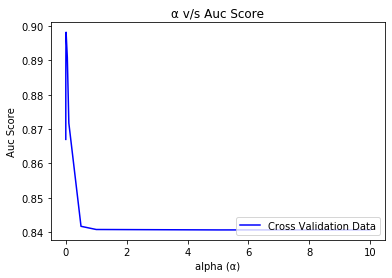

In [62]:
# Find the optimal value of alpha
# This may take several minutes to run

nb_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='Multinomial')

##### 6.2.2 TF-IDF Multinomial Naive Baye's on Test Data

The accuracy of the model is: 89.94210890556172
The macro f1_score of the model is: 75.40249092395051
The micro f1_score of the model is: 89.94210890556172
The precision_score of the model is: 89.42060846259126
The recall_score of the model is: 70.22097764812314
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.89      0.41      0.56     14351
    Positive       0.90      0.99      0.94     76682

    accuracy                           0.90     91033
   macro avg       0.89      0.70      0.75     91033
weighted avg       0.90      0.90      0.88     91033



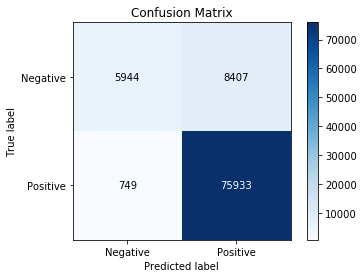

In [63]:
# Testing the final model

nb_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_alpha=0.01, algo='Multinomial')

#### Word2vec cannot be trained with Multinominal Naive Baye's algorithm because Word2Vec consists of an array of both negative and positive values and Multinomial Naive Baye's can only take positive values as input (i.e. negative input values are strictly prohibited).

# 7. Applying Bernoulli Naive Baye's Classifier on Our Model

### 7.1 Bag of Words (BoW)

##### 7.1.1 BoW Bernoulli Naive Baye's on Train Data

FOR α = 10
The accuracy of the model is: 84.06322470401562
The f1_score of the model is: 45.708819329228945
The precision_score of the model is: 61.26600001314652
The recall_score of the model is: 50.0133436798329
FOR α = 5
The accuracy of the model is: 84.06322470401562
The f1_score of the model is: 45.988039708478425
The precision_score of the model is: 66.1885645645342
The recall_score of the model is: 50.128202829058544
FOR α = 1
The accuracy of the model is: 84.73208836811914
The f1_score of the model is: 53.54107604883005
The precision_score of the model is: 75.38207043775739
The recall_score of the model is: 53.950063562157425
FOR α = 0.5
The accuracy of the model is: 86.81191260832418
The f1_score of the model is: 65.1971964851577
The precision_score of the model is: 81.75165030072498
The recall_score of the model is: 61.81164823459159
FOR α = 0.1
The accuracy of the model is: 90.80434517270841
The f1_score of the model is: 79.77542703392932
The precision_score of the model is:

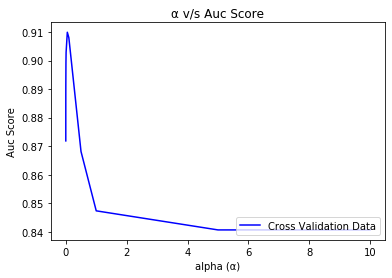

In [67]:
# Find the optimal value of alpha
# This may take several minutes(even hour/s) to run

nb_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='Bernoulli')

##### 7.1.2 BoW Bernoulli Naive Baye's on Test Data

The accuracy of the model is: 91.19000801907
The macro f1_score of the model is: 80.51869322772833
The micro f1_score of the model is: 91.19000801907
The precision_score of the model is: 88.00973672293924
The recall_score of the model is: 76.2717633070684
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.84      0.54      0.66     14351
    Positive       0.92      0.98      0.95     76682

    accuracy                           0.91     91033
   macro avg       0.88      0.76      0.81     91033
weighted avg       0.91      0.91      0.90     91033



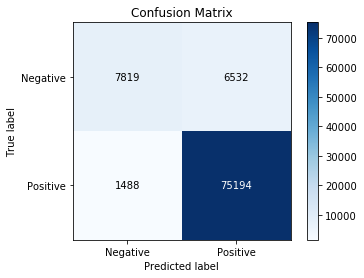

In [69]:
# Testing the final model

nb_test(x_train_bow, y_train, x_test_bow, y_test, optimal_alpha=0.05, algo='Bernoulli')

### 7.2 Term Frequency -Inverse Document Frequency (TF-IDF)

##### 7.2.1 TF-IDF Bernoulli Naive Baye's on Train Data

FOR α = 10
The accuracy of the model is: 84.06322470401562
The f1_score of the model is: 45.708819329228945
The precision_score of the model is: 61.26600001314652
The recall_score of the model is: 50.0133436798329
FOR α = 5
The accuracy of the model is: 84.06322470401562
The f1_score of the model is: 45.988039708478425
The precision_score of the model is: 66.1885645645342
The recall_score of the model is: 50.128202829058544
FOR α = 1
The accuracy of the model is: 84.73208836811914
The f1_score of the model is: 53.54107604883005
The precision_score of the model is: 75.38207043775739
The recall_score of the model is: 53.950063562157425
FOR α = 0.5
The accuracy of the model is: 86.81191260832418
The f1_score of the model is: 65.1971964851577
The precision_score of the model is: 81.75165030072498
The recall_score of the model is: 61.81164823459159
FOR α = 0.1
The accuracy of the model is: 90.80434517270841
The f1_score of the model is: 79.77542703392932
The precision_score of the model is:

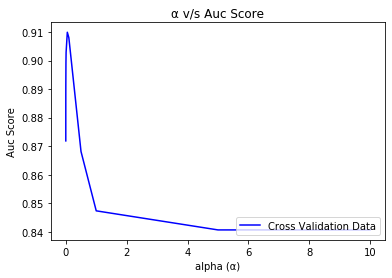

In [70]:
# Find the optimal value of alpha
# This may take several minutes to run

nb_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='Bernoulli')

##### 7.2.2 TF-IDF Bernoulli Naive Baye's on Test Data

The accuracy of the model is: 91.19000801907
The macro f1_score of the model is: 80.51869322772833
The micro f1_score of the model is: 91.19000801907
The precision_score of the model is: 88.00973672293924
The recall_score of the model is: 76.2717633070684
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.84      0.54      0.66     14351
    Positive       0.92      0.98      0.95     76682

    accuracy                           0.91     91033
   macro avg       0.88      0.76      0.81     91033
weighted avg       0.91      0.91      0.90     91033



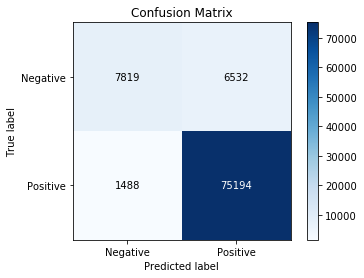

In [71]:
# Testing the final model

nb_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_alpha=0.05, algo='Bernoulli')

### 7.3 Average Word2Vec

##### 7.3.1 Avg W2V Bernoulli Naive Baye's on Train Data

FOR α = 10
The accuracy of the model is: 84.72476504332967
The f1_score of the model is: 69.40330973318511
The precision_score of the model is: 71.07311337292582
The recall_score of the model is: 68.1447821938726
FOR α = 5
The accuracy of the model is: 84.7284267057244
The f1_score of the model is: 69.41593507784883
The precision_score of the model is: 71.08187705187434
The recall_score of the model is: 68.1593772260135
FOR α = 1
The accuracy of the model is: 84.7284267057244
The f1_score of the model is: 69.41593507784883
The precision_score of the model is: 71.08187705187434
The recall_score of the model is: 68.1593772260135
FOR α = 0.5
The accuracy of the model is: 84.7284267057244
The f1_score of the model is: 69.41593507784883
The precision_score of the model is: 71.08187705187434
The recall_score of the model is: 68.1593772260135
FOR α = 0.1
The accuracy of the model is: 84.72720615159282
The f1_score of the model is: 69.41454869749275
The precision_score of the model is: 71.0793

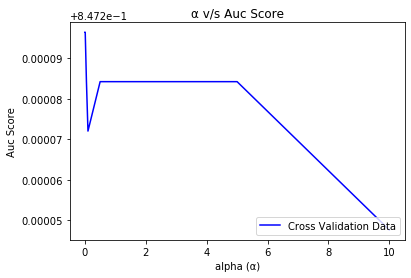

In [72]:
# Find the optimal value of alpha
# This may take several minutes to run

nb_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv, algo='Bernoulli')

##### 7.3.2 Avg W2V Bernoulli Naive Baye's on Test Data

The accuracy of the model is: 84.81210110619226
The macro f1_score of the model is: 69.45795900331007
The micro f1_score of the model is: 84.81210110619226
The precision_score of the model is: 70.99876353328231
The recall_score of the model is: 68.27193174156885
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.52      0.44      0.48     14351
    Positive       0.90      0.92      0.91     76682

    accuracy                           0.85     91033
   macro avg       0.71      0.68      0.69     91033
weighted avg       0.84      0.85      0.84     91033



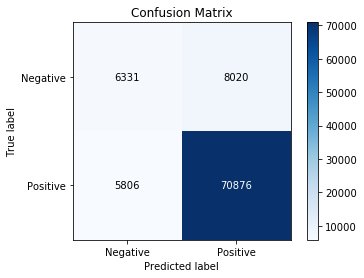

In [73]:
# Testing the final model

nb_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, optimal_alpha=0.01, algo='Bernoulli')

### 7.4 TF-IDF Weighed Word2Vec

##### 7.4.1 TF-IDF W2V Bernoulli Naive Baye's on Train Data

FOR α = 10
The accuracy of the model is: 83.74466007567436
The f1_score of the model is: 60.02628099808152
The precision_score of the model is: 67.09166486732911
The recall_score of the model is: 58.34828419990236
FOR α = 5
The accuracy of the model is: 83.73855730501649
The f1_score of the model is: 60.02421232789248
The precision_score of the model is: 67.07143512219136
The recall_score of the model is: 58.34775878986742
FOR α = 1
The accuracy of the model is: 83.73977785914806
The f1_score of the model is: 60.04014079588072
The precision_score of the model is: 67.07917582080532
The recall_score of the model is: 58.36090193746218
FOR α = 0.5
The accuracy of the model is: 83.73977785914806
The f1_score of the model is: 60.04014079588072
The precision_score of the model is: 67.07917582080532
The recall_score of the model is: 58.36090193746218
FOR α = 0.1
The accuracy of the model is: 83.73977785914806
The f1_score of the model is: 60.04014079588072
The precision_score of the model is: 

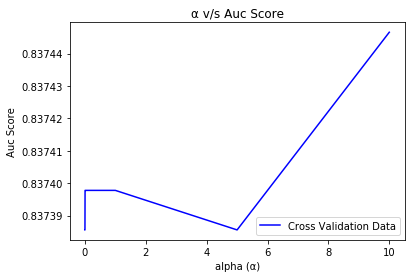

In [74]:
# Find the optimal value of alpha
# This may take several minutes to run

nb_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv, algo='Bernoulli')

##### 7.4.2 TF-IDF W2V Bernoulli Naive Baye's on Test Data

The accuracy of the model is: 83.71469686816869
The macro f1_score of the model is: 59.99914270341875
The micro f1_score of the model is: 83.71469686816869
The precision_score of the model is: 66.51408219812186
The recall_score of the model is: 58.348460112596456
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.46      0.21      0.29     14351
    Positive       0.87      0.95      0.91     76682

    accuracy                           0.84     91033
   macro avg       0.67      0.58      0.60     91033
weighted avg       0.80      0.84      0.81     91033



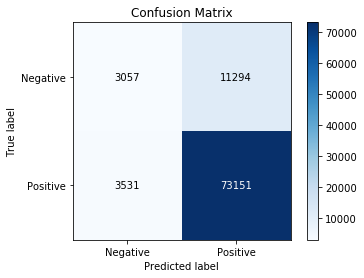

In [75]:
# Testing the final model

nb_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, optimal_alpha=10, algo='Bernoulli')